Cargando modelos...
✓ Modelos cargados exitosamente.


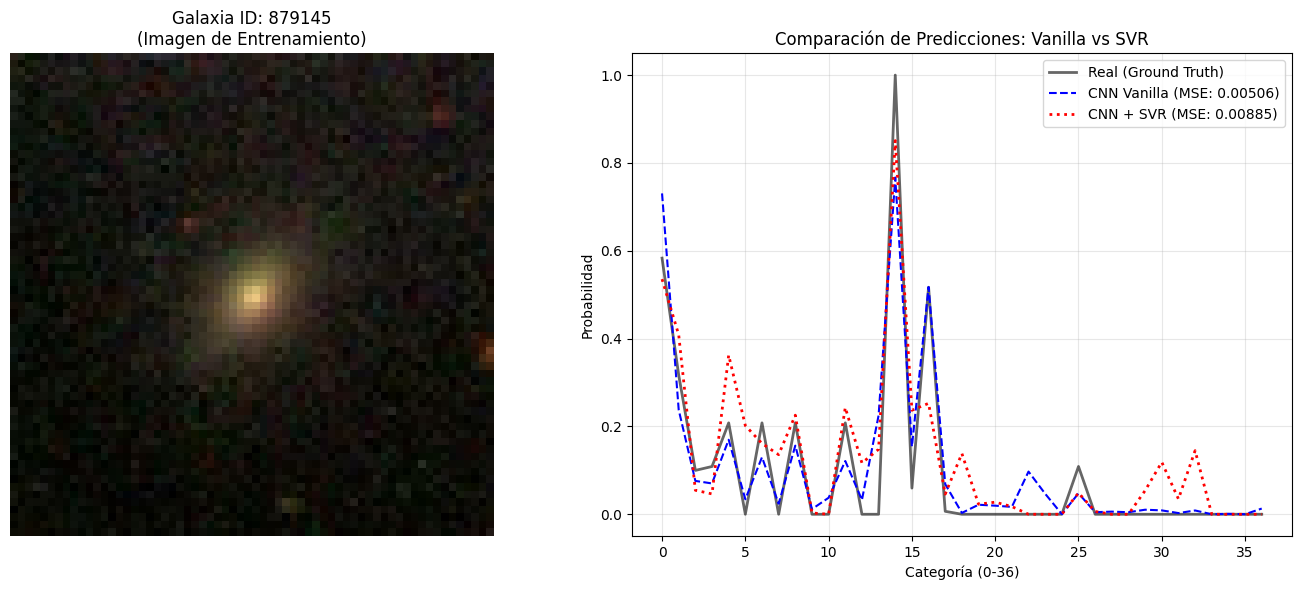


--- VEREDICTO PARA GALAXIA 879145 ---
Error Vanilla: 0.005057
Error SVR:     0.008852
🏆 GANADOR: CNN Vanilla


In [6]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. CONFIGURACIÓN (Rutas)
# ==========================================
MODEL_DIR = 'modelos_guardados'
CSV_PATH = '../GalaxyZoo/training_solutions_rev1.csv'
IMAGES_PATH = '../GalaxyZoo/images_training_rev1/' # Usamos las de training para tener la respuesta real

# ==========================================
# 2. CARGA DE MODELOS
# ==========================================
print("Cargando modelos...")

# Función custom necesaria para cargar los modelos Keras
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

try:
    # A. Cargar CNN Vanilla (El modelo puro)
    # Asegúrate de que este archivo exista. Si usaste el mismo para ambos, cambia el nombre aquí.
    cnn_vanilla = load_model(os.path.join(MODEL_DIR, 'galaxy_cnn_vanilla.keras'), 
                             custom_objects={'root_mean_squared_error': root_mean_squared_error})
    
    # B. Cargar Base CNN para SVR (Puede ser el mismo archivo 'galaxy_cnn_completo.keras')
    cnn_base_svr = load_model(os.path.join(MODEL_DIR, 'galaxy_cnn_completo.keras'), 
                              custom_objects={'root_mean_squared_error': root_mean_squared_error})
    
    # Reconstruir extractor (Buscamos la capa 'feature_layer')
    extractor = Model(inputs=cnn_base_svr.input, 
                      outputs=cnn_base_svr.get_layer('feature_layer').output)
    
    # C. Cargar SVM (Sin Scaler)
    svm = joblib.load(os.path.join(MODEL_DIR, 'galaxy_svm.joblib'))
    
    print("✓ Modelos cargados exitosamente.")

except Exception as e:
    print(f"✗ Error cargando modelos: {e}")
    print("Verifica que los archivos .keras y .joblib existan en la carpeta 'modelos_guardados'.")

# ==========================================
# 3. FUNCIÓN DE COMPARACIÓN (Sin Scaler)
# ==========================================
def comparar_modelos_random():
    # A. Obtener datos reales
    df = pd.read_csv(CSV_PATH)
    fila = df.sample(1).iloc[0]
    galaxy_id = int(fila['GalaxyID'])
    y_real = fila.values[1:].astype(float) # Las 37 probabilidades reales
    
    # B. Cargar Imagen
    ruta_img = os.path.join(IMAGES_PATH, f"{galaxy_id}.jpg")
    try:
        img_raw = tf.io.read_file(ruta_img)
        img = tf.io.decode_image(img_raw, channels=3)
        img = tf.image.resize(img, [64, 64])
        img = img / 255.0
        img_tensor = np.expand_dims(img.numpy(), axis=0)
    except Exception as e:
        print(f"No se pudo leer la imagen {galaxy_id}: {e}")
        return

    # C. Predicciones
    
    # 1. Modelo Vanilla (Directo)
    pred_vanilla = cnn_vanilla.predict(img_tensor, verbose=0)[0]
    
    # 2. Modelo Híbrido CNN+SVR (Sin Scaler)
    features = extractor.predict(img_tensor, verbose=0)
    # PASO DIRECTO: Features -> SVM (Saltamos el scaler.transform)
    pred_svr = svm.predict(features)[0]
    pred_svr = np.clip(pred_svr, 0.0, 1.0)

    # D. Cálculo de Errores (MSE)
    mse_vanilla = np.mean((y_real - pred_vanilla)**2)
    mse_svr = np.mean((y_real - pred_svr)**2)

    # E. Visualización
    plt.figure(figsize=(14, 6))
    
    # Imagen de la Galaxia
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Galaxia ID: {galaxy_id}\n(Imagen de Entrenamiento)")
    plt.axis('off')
    
    # Gráfico de Líneas
    plt.subplot(1, 2, 2)
    x = np.arange(37)
    
    plt.plot(x, y_real, 'k-', label='Real (Ground Truth)', linewidth=2, alpha=0.6)
    plt.plot(x, pred_vanilla, 'b--', label=f'CNN Vanilla (MSE: {mse_vanilla:.5f})')
    plt.plot(x, pred_svr, 'r:', label=f'CNN + SVR (MSE: {mse_svr:.5f})', linewidth=2)
    
    plt.title("Comparación de Predicciones: Vanilla vs SVR")
    plt.xlabel("Categoría (0-36)")
    plt.ylabel("Probabilidad")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Veredicto en texto
    print(f"\n--- VEREDICTO PARA GALAXIA {galaxy_id} ---")
    print(f"Error Vanilla: {mse_vanilla:.6f}")
    print(f"Error SVR:     {mse_svr:.6f}")
    if mse_svr < mse_vanilla:
        print("🏆 GANADOR: CNN + SVR")
    else:
        print("🏆 GANADOR: CNN Vanilla")

# ==========================================
# 4. EJECUTAR
# ==========================================
comparar_modelos_random()